# Named Topologies

A lot of specific problems are tailored to specific hardware topologies of qubits; or a problem is defined on a structured topology and mapped to a hardware topology. Specific examples:

1. QAOA "hardware grid" topologies are defined on subgraphs of a device's topology. There's a freedom in choosing which n-qubit subgraph. For the paper, we chose a "central" qubit and chose qubits radially outwards from it until the whole graph was covered.
2. HFVQE and QAOA SK model topologies assume linear connectivity of a given size which can be snaked on a device.
3. Characterization routines usually implicitly or explicitly characterize circuits on a topology, often the whole device.

When discussing a hardware topology, it can be convenient to use the processor id (aka device name) as a proxy for the topology. Unfortunately, a given processor is not guaranteed to have a stable hardware topology. Indeed: `rainbow` has grown from `Sycamore23` to its current, larger configuration. For experimental record-keeping, it's important to have a fixed topology. Furthermore: to support comparisons between multiple processors with compatible hardware graphs (i.e. one is a subset-or-equal to another) it could be useful to have a "problem topology" decoupled from a hardware topology.

A simple "record keeping" approach would be to serialize the device graph for each problem. However, there is often considerable structure in these topologies (e.g. "this was a device graph" or "this is a line"). Additionally, for ReCirq's data collection idioms to be effective it is necessary to have a descriptive "hash" of all parameters (so they can be used as inputs, shared between dependent tasks, used as parts of the filename).

Therefore, I propose we have 1) a set of problem topology classes and 2) A name-to-topolgy mapping.

## Line

In [2]:
import networkx as nx

class LineTopology:
    def __init__(self, n_qubits):
        self.n_qubits = n_qubits
        self.name = f'{self.n_qubits}q-line'
        self.graph = nx.from_edgelist([(i1, i2) for i1, i2 
                                       in zip(range(self.n_qubits), range(1, self.n_qubits))])           

6q-line


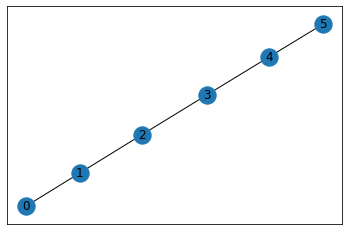

In [3]:
%matplotlib inline
line = LineTopology(6)
nx.draw_networkx(line.graph)
print(line.name)

## Device-Based

In [4]:
import cirq
def draw_gridlike(graph, highlight=None, **kwargs):
    pos = {}
    for node in graph.nodes:
        if isinstance(node, cirq.GridQubit):
            pos[node] = node.col, node.row
        elif isinstance(node, tuple):
            row, col = node
            pos[node] = col, row
        else:
            raise ValueError("Don't know how to position {}".format(node))
            
    if highlight is not None:
        colors=['grey' if n not in highlight else 'red' for n in graph.nodes]
    else:
        colors=None
            
    nx.draw_networkx(graph, pos=pos, node_color=colors, **kwargs)

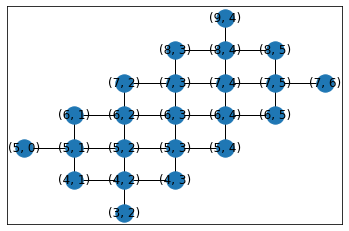

In [5]:
import cirq.google as cg
import cirq.contrib.routing as ccr

syc23_graph = ccr.gridqubits_to_graph_device(cg.Sycamore23.qubits)
draw_gridlike(syc23_graph)

In [6]:
print("SYC23_GRAPH = nx.from_edgelist([\n    ", end='')
i = 0
for e1, e2 in sorted(syc23_graph.edges):
    print(f'(({e1.row}, {e1.col}), ({e2.row}, {e2.col})),', end=' ')
    i += 1
    if i % 3 == 0:
        print('\n', end='    ')
print("\n])")    

SYC23_GRAPH = nx.from_edgelist([
    ((3, 2), (4, 2)), ((4, 1), (5, 1)), ((4, 2), (4, 1)), 
    ((4, 2), (4, 3)), ((4, 2), (5, 2)), ((4, 3), (5, 3)), 
    ((5, 1), (5, 0)), ((5, 1), (5, 2)), ((5, 1), (6, 1)), 
    ((5, 2), (5, 3)), ((5, 2), (6, 2)), ((5, 3), (5, 4)), 
    ((5, 3), (6, 3)), ((5, 4), (6, 4)), ((6, 1), (6, 2)), 
    ((6, 2), (6, 3)), ((6, 2), (7, 2)), ((6, 3), (6, 4)), 
    ((6, 3), (7, 3)), ((6, 4), (6, 5)), ((6, 4), (7, 4)), 
    ((6, 5), (7, 5)), ((7, 2), (7, 3)), ((7, 3), (7, 4)), 
    ((7, 3), (8, 3)), ((7, 4), (7, 5)), ((7, 4), (8, 4)), 
    ((7, 5), (7, 6)), ((7, 5), (8, 5)), ((8, 3), (8, 4)), 
    ((8, 4), (8, 5)), ((8, 4), (9, 4)), 
])


rainbow


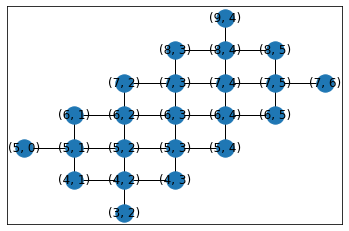

In [7]:
SYC23_GRAPH = nx.from_edgelist([
    ((3, 2), (4, 2)), ((4, 1), (5, 1)), ((4, 2), (4, 1)), 
    ((4, 2), (4, 3)), ((4, 2), (5, 2)), ((4, 3), (5, 3)), 
    ((5, 1), (5, 0)), ((5, 1), (5, 2)), ((5, 1), (6, 1)), 
    ((5, 2), (5, 3)), ((5, 2), (6, 2)), ((5, 3), (5, 4)), 
    ((5, 3), (6, 3)), ((5, 4), (6, 4)), ((6, 1), (6, 2)), 
    ((6, 2), (6, 3)), ((6, 2), (7, 2)), ((6, 3), (6, 4)), 
    ((6, 3), (7, 3)), ((6, 4), (6, 5)), ((6, 4), (7, 4)), 
    ((6, 5), (7, 5)), ((7, 2), (7, 3)), ((7, 3), (7, 4)), 
    ((7, 3), (8, 3)), ((7, 4), (7, 5)), ((7, 4), (8, 4)), 
    ((7, 5), (7, 6)), ((7, 5), (8, 5)), ((8, 3), (8, 4)), 
    ((8, 4), (8, 5)), ((8, 4), (9, 4)), 
])

class DeviceBasedTopology:
    def __init__(self, graph, assoc_processor_id, epoch=1):
        self.graph = graph
        self.n_qubits = graph.number_of_nodes()
        self.assoc_processor_id = assoc_processor_id
        self.epoch = epoch
        
        if epoch != 1:
            epoch_str = f'-mk{epoch}'
        else: epoch_str = ''
        
        self.name = f'{assoc_processor_id}{epoch_str}'
        
RAINBOW_TOPOLOGY = DeviceBasedTopology(
    graph=SYC23_GRAPH,
    assoc_processor_id='rainbow',
    epoch=1
)
draw_gridlike(RAINBOW_TOPOLOGY.graph)
print(RAINBOW_TOPOLOGY.name)

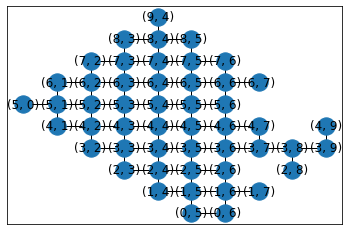

In [8]:
syc50 = cg.get_engine_device(processor_id='rainbow', project_id='google.com:quantum-experiments')
syc50_graph = ccr.gridqubits_to_graph_device(syc50.qubits)
draw_gridlike(syc50_graph)

In [9]:
print("SYC50_GRAPH = nx.from_edgelist([\n    ", end='')
i = 0
for e1, e2 in sorted(syc50_graph.edges):
    print(f'(({e1.row}, {e1.col}), ({e2.row}, {e2.col})),', end=' ')
    i += 1
    if i % 4 == 0:
        print('\n', end='    ')
print("\n])")    

SYC50_GRAPH = nx.from_edgelist([
    ((0, 6), (0, 5)), ((1, 4), (1, 5)), ((1, 5), (0, 5)), ((1, 6), (0, 6)), 
    ((1, 6), (1, 5)), ((1, 7), (1, 6)), ((2, 3), (2, 4)), ((2, 3), (3, 3)), 
    ((2, 4), (1, 4)), ((2, 5), (1, 5)), ((2, 5), (2, 4)), ((2, 5), (2, 6)), 
    ((2, 6), (1, 6)), ((3, 3), (3, 2)), ((3, 3), (4, 3)), ((3, 4), (2, 4)), 
    ((3, 4), (3, 3)), ((3, 4), (4, 4)), ((3, 5), (2, 5)), ((3, 5), (3, 4)), 
    ((3, 5), (3, 6)), ((3, 5), (4, 5)), ((3, 6), (2, 6)), ((3, 6), (3, 7)), 
    ((3, 6), (4, 6)), ((3, 7), (3, 8)), ((3, 8), (2, 8)), ((3, 9), (3, 8)), 
    ((4, 1), (5, 1)), ((4, 2), (3, 2)), ((4, 2), (4, 1)), ((4, 3), (4, 2)), 
    ((4, 3), (4, 4)), ((4, 5), (4, 4)), ((4, 5), (4, 6)), ((4, 5), (5, 5)), 
    ((4, 6), (4, 7)), ((4, 6), (5, 6)), ((4, 7), (3, 7)), ((4, 9), (3, 9)), 
    ((5, 1), (5, 0)), ((5, 2), (4, 2)), ((5, 2), (5, 1)), ((5, 3), (4, 3)), 
    ((5, 3), (5, 2)), ((5, 3), (5, 4)), ((5, 3), (6, 3)), ((5, 4), (4, 4)), 
    ((5, 5), (5, 4)), ((5, 6), (5, 5)), ((5

rainbow-mk2


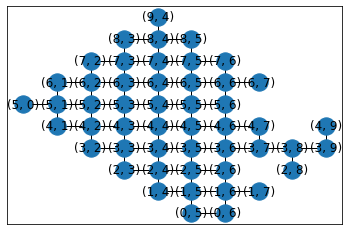

In [10]:
SYC50_GRAPH = nx.from_edgelist([
    ((0, 6), (0, 5)), ((1, 4), (1, 5)), ((1, 5), (0, 5)), ((1, 6), (0, 6)), 
    ((1, 6), (1, 5)), ((1, 7), (1, 6)), ((2, 3), (2, 4)), ((2, 3), (3, 3)), 
    ((2, 4), (1, 4)), ((2, 5), (1, 5)), ((2, 5), (2, 4)), ((2, 5), (2, 6)), 
    ((2, 6), (1, 6)), ((3, 3), (3, 2)), ((3, 3), (4, 3)), ((3, 4), (2, 4)), 
    ((3, 4), (3, 3)), ((3, 4), (4, 4)), ((3, 5), (2, 5)), ((3, 5), (3, 4)), 
    ((3, 5), (3, 6)), ((3, 5), (4, 5)), ((3, 6), (2, 6)), ((3, 6), (3, 7)), 
    ((3, 6), (4, 6)), ((3, 7), (3, 8)), ((3, 8), (2, 8)), ((3, 9), (3, 8)), 
    ((4, 1), (5, 1)), ((4, 2), (3, 2)), ((4, 2), (4, 1)), ((4, 3), (4, 2)), 
    ((4, 3), (4, 4)), ((4, 5), (4, 4)), ((4, 5), (4, 6)), ((4, 5), (5, 5)), 
    ((4, 6), (4, 7)), ((4, 6), (5, 6)), ((4, 7), (3, 7)), ((4, 9), (3, 9)), 
    ((5, 1), (5, 0)), ((5, 2), (4, 2)), ((5, 2), (5, 1)), ((5, 3), (4, 3)), 
    ((5, 3), (5, 2)), ((5, 3), (5, 4)), ((5, 3), (6, 3)), ((5, 4), (4, 4)), 
    ((5, 5), (5, 4)), ((5, 6), (5, 5)), ((5, 6), (6, 6)), ((6, 1), (5, 1)), 
    ((6, 2), (5, 2)), ((6, 2), (6, 1)), ((6, 2), (6, 3)), ((6, 4), (5, 4)), 
    ((6, 4), (6, 3)), ((6, 4), (7, 4)), ((6, 5), (5, 5)), ((6, 5), (6, 4)), 
    ((6, 5), (6, 6)), ((6, 5), (7, 5)), ((6, 6), (6, 7)), ((6, 6), (7, 6)), 
    ((7, 2), (6, 2)), ((7, 2), (7, 3)), ((7, 3), (6, 3)), ((7, 3), (7, 4)), 
    ((7, 3), (8, 3)), ((7, 5), (7, 4)), ((7, 5), (7, 6)), ((7, 5), (8, 5)), 
    ((8, 4), (7, 4)), ((8, 4), (8, 3)), ((8, 4), (8, 5)), ((8, 4), (9, 4)),   
])

RAINBOW_MK2_TOPOLOGY = DeviceBasedTopology(
    graph=SYC50_GRAPH,
    assoc_processor_id='rainbow',
    epoch=2
)
draw_gridlike(RAINBOW_MK2_TOPOLOGY.graph)
print(RAINBOW_MK2_TOPOLOGY.name)

## Rectangle

5x3-grid


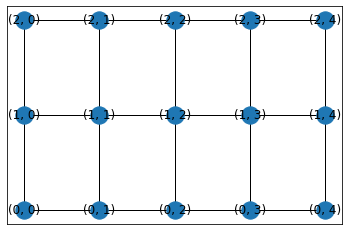

In [11]:
class GridTopology:
    def __init__(self, width, height):
        self.graph = nx.grid_2d_graph(height, width)
        self.n_qubits = width * height
        self.name = f'{width}x{height}-grid'

grid_topo = GridTopology(5, 3)
print(grid_topo.name)
draw_gridlike(grid_topo.graph)

In [12]:
from networkx.algorithms.isomorphism import GraphMatcher

matcher = GraphMatcher(RAINBOW_MK2_TOPOLOGY.graph, grid_topo.graph)
mapping_big_to_small = next(matcher.subgraph_isomorphisms_iter())
mapping_small_to_big = {v: k for k, v in mapping_big_to_small.items()}
mapping_small_to_big

{(0, 0): (1, 4),
 (0, 1): (2, 4),
 (0, 2): (3, 4),
 (0, 3): (4, 4),
 (0, 4): (5, 4),
 (1, 0): (1, 5),
 (1, 1): (2, 5),
 (1, 2): (3, 5),
 (1, 3): (4, 5),
 (1, 4): (5, 5),
 (2, 0): (1, 6),
 (2, 1): (2, 6),
 (2, 2): (3, 6),
 (2, 3): (4, 6),
 (2, 4): (5, 6)}

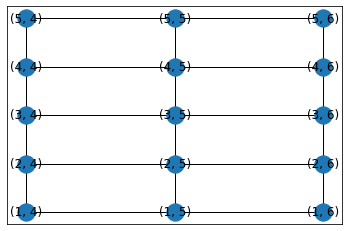

In [13]:
relabeled_grid = nx.relabel_nodes(grid_topo.graph, mapping_small_to_big)
draw_gridlike(relabeled_grid)

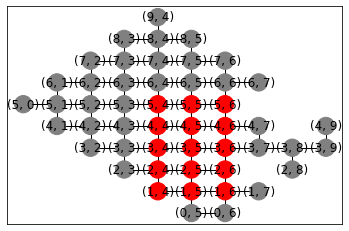

In [14]:
draw_gridlike(RAINBOW_MK2_TOPOLOGY.graph, highlight=relabeled_grid.nodes)

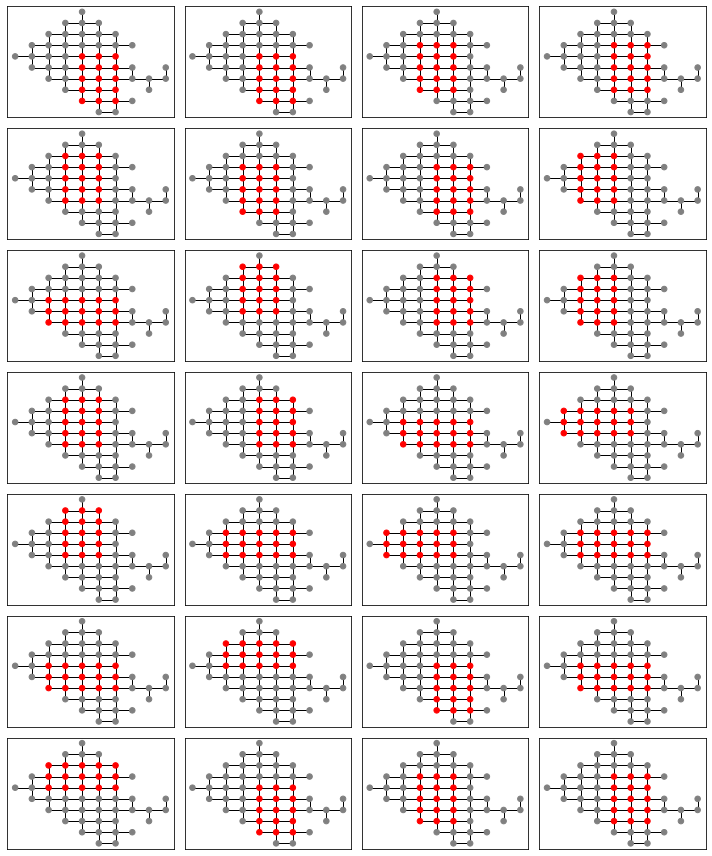

In [15]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(7, 4, figsize=(10,12))

matcher = GraphMatcher(RAINBOW_MK2_TOPOLOGY.graph, grid_topo.graph)
for mapping_big_to_small, ax in zip(matcher.subgraph_isomorphisms_iter(), axes.reshape(-1)):
    plt.subplot(ax)
    draw_gridlike(RAINBOW_MK2_TOPOLOGY.graph, highlight=mapping_big_to_small.keys(), node_size=30, with_labels=False)
plt.tight_layout()

In [16]:
matcher = GraphMatcher(RAINBOW_MK2_TOPOLOGY.graph, grid_topo.graph)
sum(1 for _ in matcher.subgraph_isomorphisms_iter())

44